In [1]:
import os
import sys
import inspect
from importlib import reload
from tqdm import tqdm
from pathlib import Path

import numpy as np
import numexpr as ne
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.constants import pi, c, epsilon_0, mu_0, alpha, m_e, hbar, e
import pyfftw

rcParams['figure.figsize'] = (8,6)
rcParams['font.size'] = 20

import quvac
from quvac.field.paraxial_gaussian import ParaxialGaussianAnalytic
from quvac.field.external_field import ExternalField
from quvac.field.maxwell import ParaxialGaussianMaxwell
from quvac.field.utils import get_field_energy, get_field_energy_kspace
from quvac.integrator.vacuum_emission import VacuumEmission
from quvac.analytic_scalings import get_two_paraxial_scaling
from quvac.grid import GridXYZ
from quvac.grid_utils import get_xyz_size, get_t_size, setup_grids
from quvac.utils import write_yaml, read_yaml
from quvac.simulation import quvac_simulation
reload(quvac.simulation)
reload(quvac.field.maxwell)
reload(quvac.field.abc)

<module 'quvac.field.abc' from '/home/maximus/Research/github/quantum-vacuum/src/quvac/field/abc.py'>

## Launch a single simulation

In [2]:
# Define field parameters
tau = 25e-15
W = 25
lam = 0.8e-6
w0 = 1*lam
theta = 180
beta = 0

mode = 'analytic'

# Define fields
field_1 = {
    "field_type": f"paraxial_gaussian_{mode}",
    "focus_x": [0.,0.,0.],
    "focus_t": 0.,
    "theta": 0,
    "phi": 0,
    "beta": 0,
    "lam": lam,
    "w0": w0,
    "tau": tau,
    "W": W,
    "phase0": 0,
}

field_2 = {
    "field_type": f"paraxial_gaussian_{mode}",
    "focus_x": [0.,0.,0.],
    "focus_t": 0.,
    "theta": theta,
    "phi": 0,
    "beta": beta,
    "lam": lam,
    "w0": w0,
    "tau": tau,
    "W": W,
    "phase0": 0,
}

fields_params = [field_1, field_2]
# fields_params = [field_1]

# x0, y0, z0 = 5*c*tau, 15*w0, 5*c*tau
x0, y0, z0 = 15*w0, 15*w0, 6*c*tau
print(x0, y0, z0)
box_size = np.array([x0, y0, z0])/2
Nxyz = get_xyz_size(fields_params, box_size)
Nx, Ny, Nz = [1*N for N in Nxyz]
print(Nx, Ny, Nz)

t0 = 4*tau
Nt = get_t_size(-t0/2, t0/2, lam)

ini_data = {
    'fields': fields_params,
    'grid': {
        'mode': 'direct',
        'box_xyz': [x0,y0,z0],
        'Nxyz': [Nx,Ny,Nz],
        # 'Nxyz': [Nx,int(1.2*Ny),Nz],
        'box_t': t0,
        'Nt': Nt
    },
    'performance': {
        'nthreads': 8
    }
}

path = '../data/test_maxwell_one_field'
Path(path).mkdir(parents=True, exist_ok=True)

ini_file = os.path.join(path, 'ini.yaml')
write_yaml(ini_file, ini_data)

# quvac_simulation(ini_file)
SCRIPT_PATH = '../src/quvac/simulation.py'

1.2e-05 1.2e-05 4.49688687e-05
30 30 192


In [3]:
status = os.system(f"{SCRIPT_PATH} --input {ini_file}")


Timings:
Field setup:                        0.07 s
Vacem setup:                        0.01 s
Amplitudes calculation:            12.74 s
Postprocess:                        0.05 s
-------------------------------------------------
Per iteration:                      0.06 s  
-------------------------------------------------
Total:                             12.87 s

Memory (max usage):
Amplitudes calculation:          187.99 MB
Total:                           187.99 MB

Simulation finished!


In [6]:
data_file = os.path.join(path, 'spectra.npz')
data = np.load(data_file)
print(list(data.keys()))

['kx', 'ky', 'kz', 'N_xyz', 'N_tot', 'ep', 'Np_xyz', 'Np_tot']


In [7]:
N_signal_num = data['N_tot']
print(N_signal_num)

283.3338967156451


In [6]:
N_signal_th, N_perp_th = get_two_paraxial_scaling(fields_params)
N_signal_th

454.084116068451

In [7]:
N_signal_th / N_signal_num

1.602646634702384

### Test how a1, a2 look like

In [10]:
ini_config = read_yaml(ini_file)
fields_params = ini_config["fields"]
grid_params = ini_config["grid"]
perf_params = ini_config["performance"]
nthreads = perf_params['nthreads']

grid_xyz, grid_t = setup_grids(fields_params, grid_params)
field = ExternalField(fields_params, grid_xyz, nthreads=nthreads)
grid_xyz.get_k_grid()
dVk = grid_xyz.dVk

amplitudes_path = os.path.join(path, 'amplitudes.npz')
data = np.load(amplitudes_path)
s1, s2 = data['S1'], data['S2']

s1_real = np.sum(s1.real) * dVk / (2*pi)**3
s1_imag = np.sum(s1.imag) * dVk / (2*pi)**3

s2_real = np.sum(s2.real) * dVk / (2*pi)**3
s2_imag = np.sum(s2.imag) * dVk / (2*pi)**3
print(f's1 real: {s1_real}')
print(f's1 imag: {s1_imag}')

print(f's2 real: {s2_real}')
print(f's2 imag: {s2_imag}')

s1 real: 1.5672026691683959e-09
s1 imag: -9.877871510245512e-09
s2 real: 3.360367860975565e-09
s2 imag: -1.6330722306896097e-08


In [18]:
x,y,z = grid_xyz.grid
grid_shape = nx,ny,nz = grid_xyz.grid_shape
E_out = [np.zeros(grid_shape) for _ in range(3)]
B_out = [np.zeros(grid_shape) for _ in range(3)]

t = 1e-15
E_out, B_out = field.calculate_field(t, E_out, B_out)

W = get_field_energy(E_out, B_out, grid_xyz.dV)
print(W)

49.99999997570632


5022939.295592608
148394.57312882377


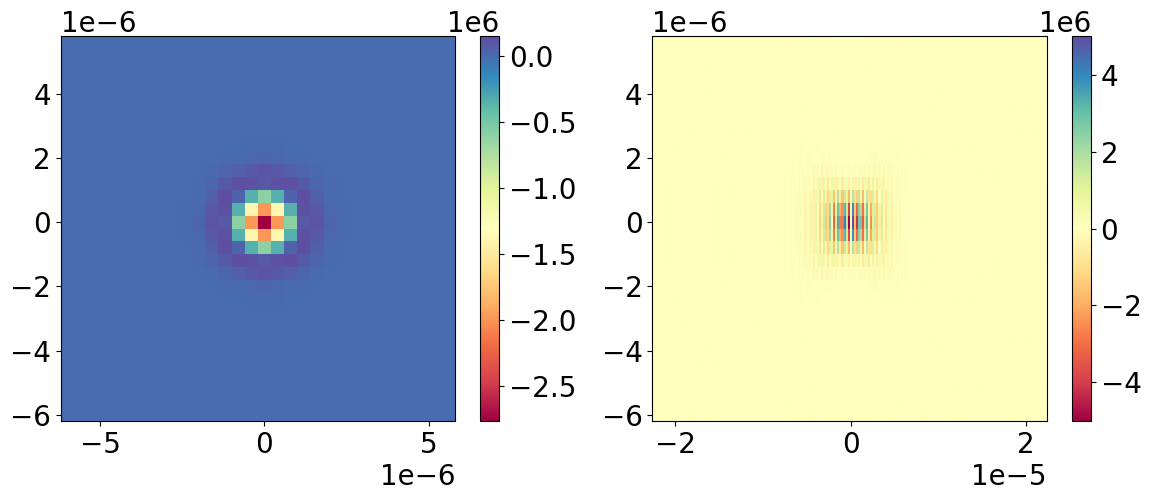

In [17]:
E = E_out[0]
print(E.max())
idx = nz//2-5
print(E[:,:,idx].max())

idx = nz//2-5
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.pcolormesh(x, y, np.real(E[:,:,idx]), cmap='Spectral')
plt.colorbar()

idx = 15
plt.subplot(1,2,2)
plt.pcolormesh(z, x, np.real(E[:,idx,:]), cmap='Spectral')
plt.colorbar()
plt.show()

In [13]:
3822599 / 3773914

1.01290039995612

In [7]:
maxwell_f = field.fields[0]
kabs = maxwell_f.kabs
a1 = maxwell_f.a1 #/ (1j*kabs)
# a1[0,0,0] = 0.
a2 = maxwell_f.a2 #/ (1j*kabs)
# a2[0,0,0] = 0.

a1 = np.fft.fftshift(a1)
a2 = np.fft.fftshift(a2)

In [8]:
kx = np.fft.fftshift(maxwell_f.kx.flatten())
ky = np.fft.fftshift(maxwell_f.ky.flatten())
kz = np.fft.fftshift(maxwell_f.kz.flatten())
kabs = np.fft.fftshift(maxwell_f.kabs)
# kx /= kabs
# ky /= kabs
# kz /= kabs
nx, ny, nz = len(kx), len(ky), len(kz)

1.2454082596793964e-17


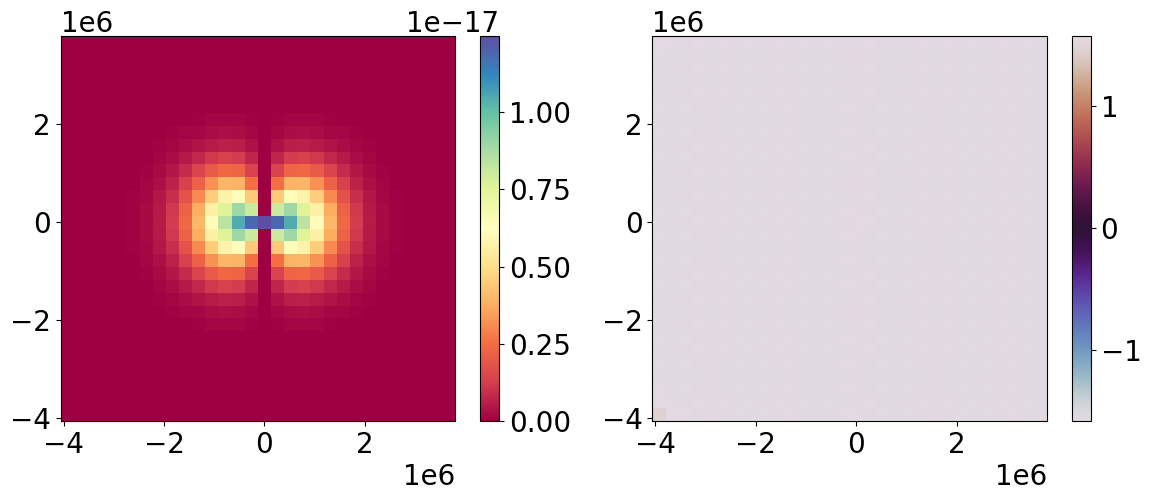

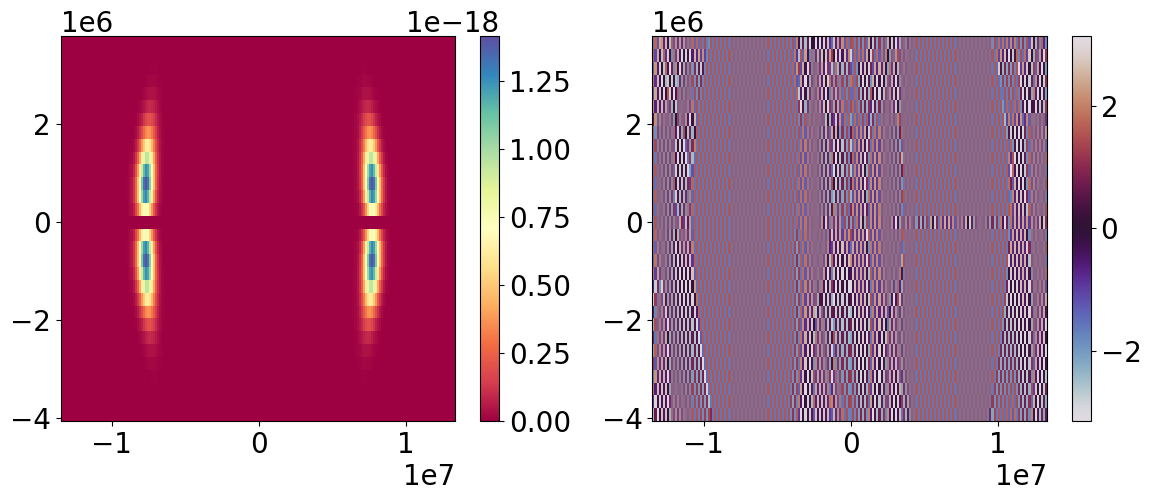

In [9]:
a = a2

idx = 40
# idx = nz//2
print(np.max(np.abs(np.array(a2[:,:,idx]))))

# ======================================
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.pcolormesh(kx, ky, np.abs(a2[:,:,idx]).T, cmap='Spectral')
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolormesh(kx, ky, np.angle(a2[:,:,idx]).T, cmap='twilight')
plt.colorbar()
plt.show()

# ======================================
idx = 10
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.pcolormesh(kz, kx, np.abs(a2[:,idx,:]), cmap='Spectral')
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolormesh(kz, kx, np.angle(a2[:,idx,:]), cmap='twilight')
plt.colorbar()
plt.show()

1.2454082596793964e-17


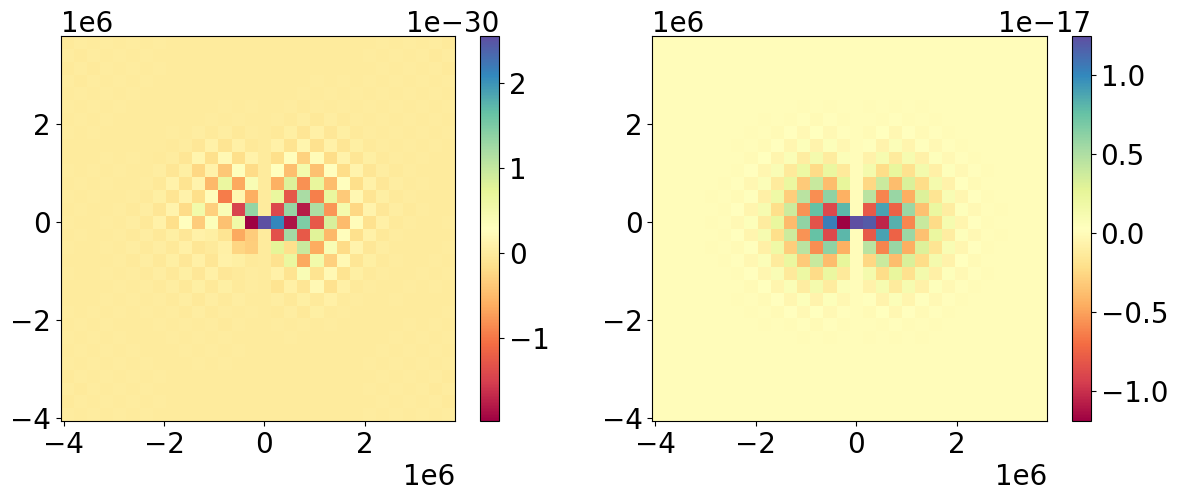

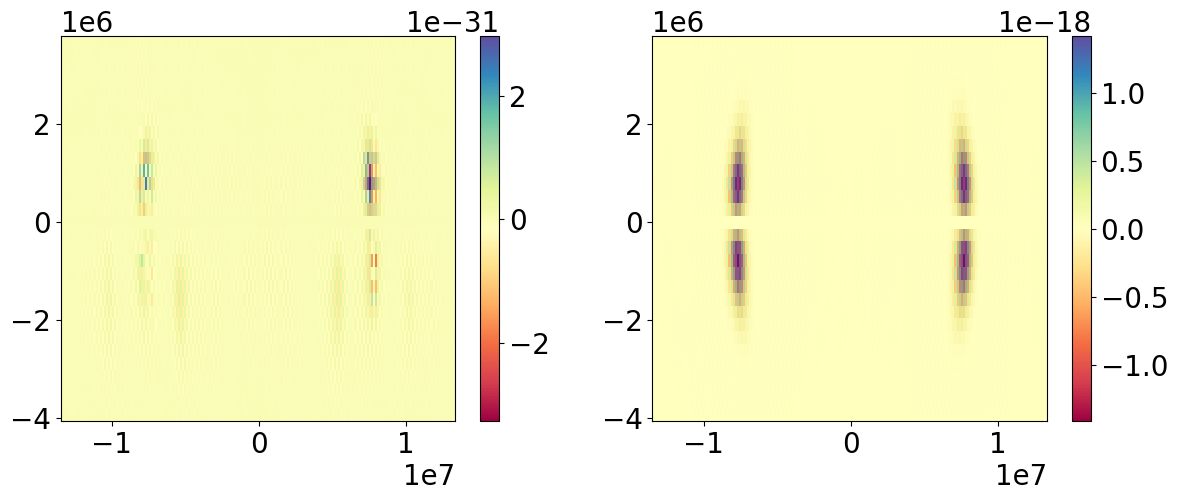

In [10]:
a = a2

idx = 40
# idx = nz//2
print(np.max(np.abs(np.array(a2[:,:,idx]))))

# ======================================
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.pcolormesh(kx, ky, np.real(a[:,:,idx]).T, cmap='Spectral')
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolormesh(kx, ky, np.imag(a[:,:,idx]).T, cmap='Spectral')
plt.colorbar()
plt.show()

# ======================================
idx = 10
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.pcolormesh(kz, kx, np.real(a[:,idx,:]), cmap='Spectral')
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolormesh(kz, kx, np.imag(a[:,idx,:]), cmap='Spectral')
plt.colorbar()
plt.show()

In [11]:
# Test how fields after fourier look like
grid_shape = grid_xyz.grid_shape
x,y,z = grid_xyz.grid

t = 0e-15
E_out = [np.zeros(grid_shape, dtype=np.complex128) for _ in range(3)]
B_out = [np.zeros(grid_shape, dtype=np.complex128) for _ in range(3)]
E, B = field.calculate_field(t, E_out, B_out)
# E = [np.fft.fftshift(Ex) for Ex in E]
# B = [np.fft.fftshift(Bx) for Bx in B]

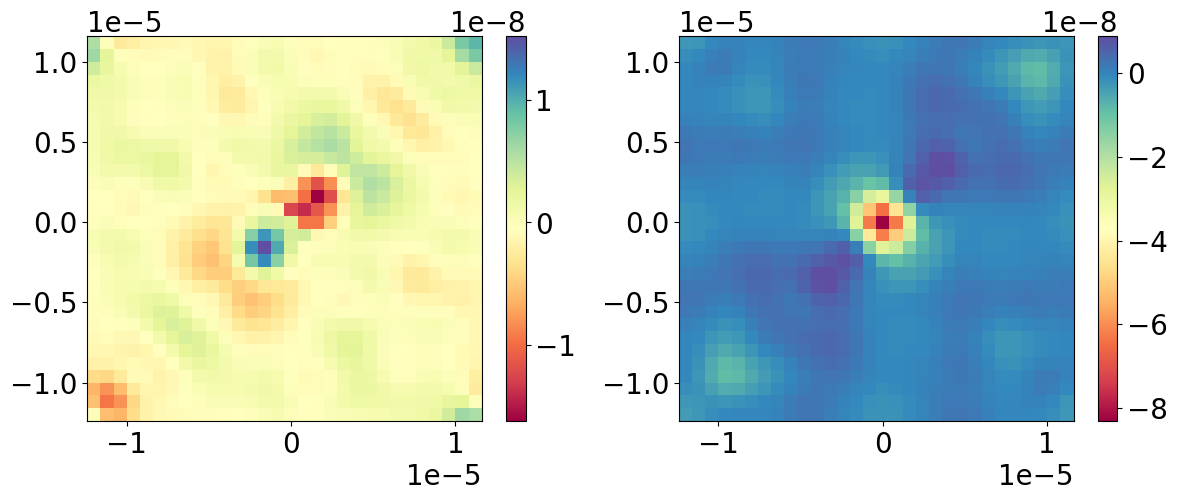

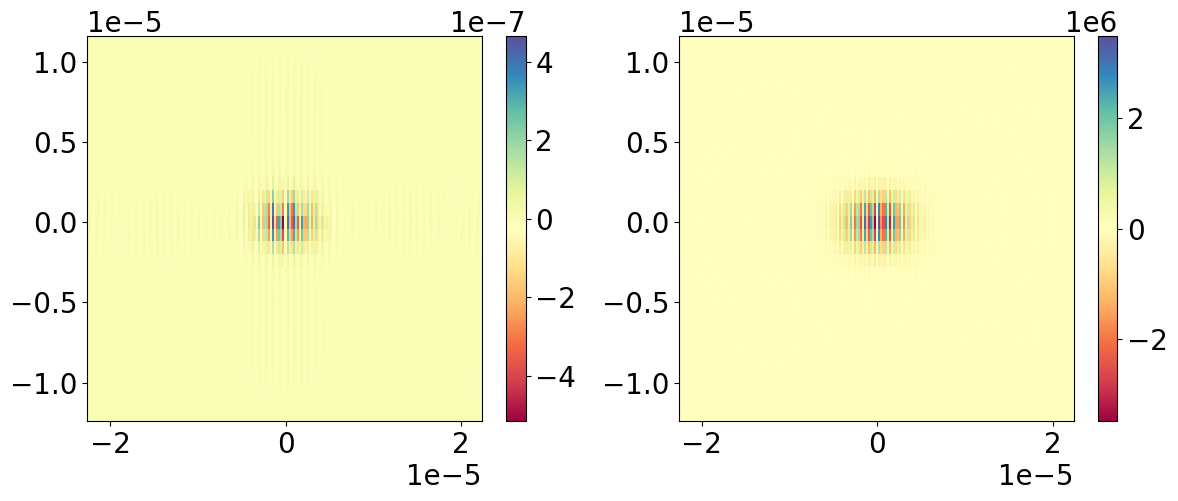

In [12]:
idx = nz//2
# idx = 10

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.pcolormesh(x, y, np.real(E[0][:,:,idx]), cmap='Spectral')
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolormesh(x, y, np.imag(E[0][:,:,idx]), cmap='Spectral')
plt.colorbar()
plt.show()

idx = 15
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.pcolormesh(z, x, np.real(E[0][:,idx,:]), cmap='Spectral')
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolormesh(z, x, np.imag(E[0][:,idx,:]), cmap='Spectral')
plt.colorbar()
plt.show()

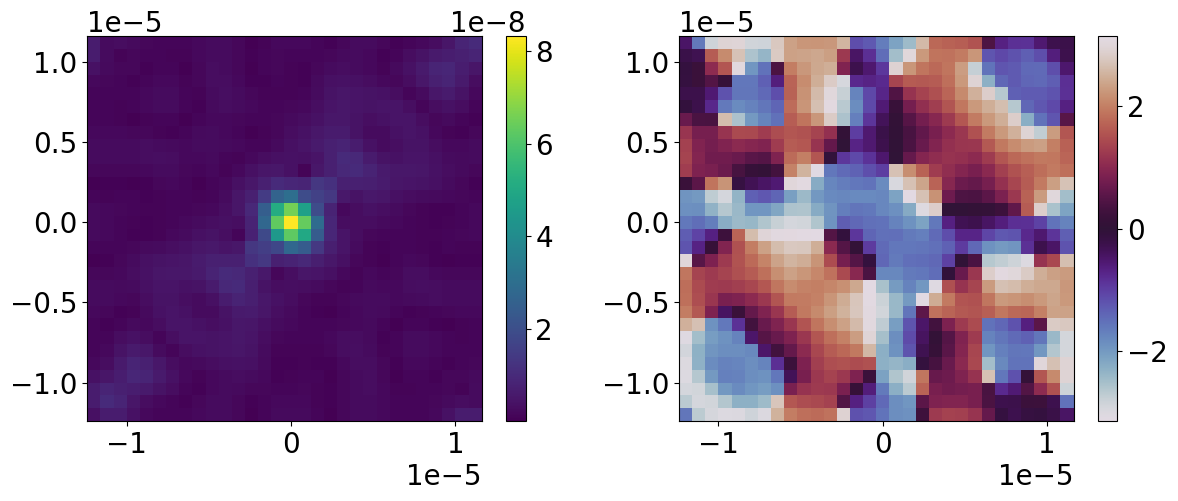

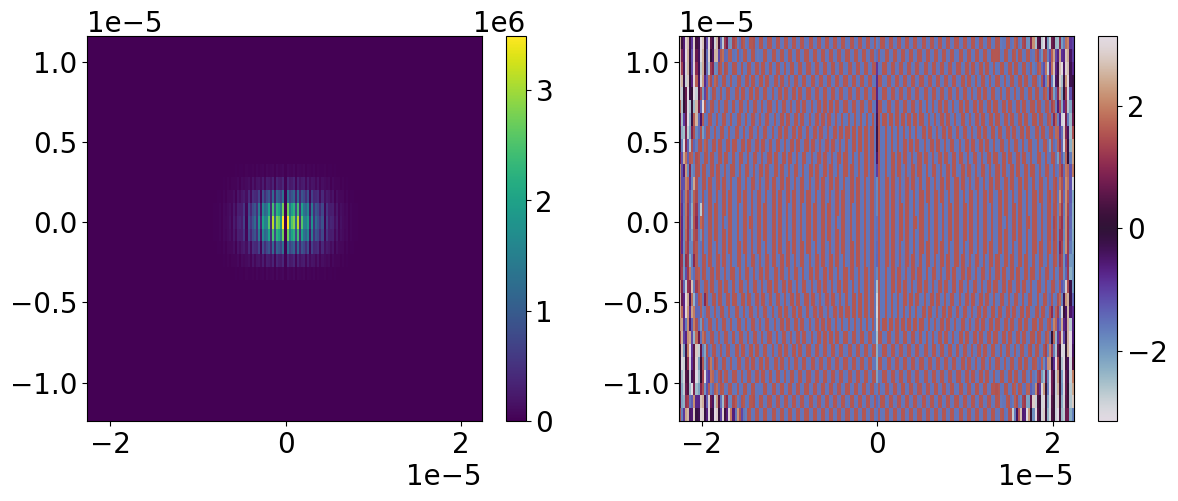

In [13]:
# E_ini = field.fields[0].E_ini

idx = nz//2
# idx = 10

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.pcolormesh(y, x, np.abs(E[0][:,:,idx]))
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolormesh(y, x, np.angle(E[0][:,:,idx]), cmap='twilight')
plt.colorbar()
plt.show()

# ==================================================
# idx = ny//2
idx = 15

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.pcolormesh(z, x, np.abs(E[0][:,idx,:]))
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolormesh(z, x, np.angle(E[0][:,idx,:]), cmap='twilight')
plt.colorbar()
plt.show()

## Run quvac amplitude calculation with a1 a2 from vacem

In [42]:
data_folder = '/home/maximus/Research/github/quantum-vacuum/data'

ini_config = read_yaml(ini_file)
fields_params = ini_config["fields"]
grid_params = ini_config["grid"]
perf_params = ini_config["performance"]
nthreads = perf_params['nthreads']

grid_xyz, grid_t = setup_grids(fields_params, grid_params)
field = ExternalField(fields_params, grid_xyz, nthreads=nthreads)

We enter multiple gaussian
Ho-ho
Solo parameter
24.841191297440023
Ho-ho
Solo parameter
24.841191297439998


In [44]:
data_path = f'{data_folder}/a_spectrum/a1a2.npz'
data = np.load(data_path)
a1, a2 = np.fft.ifftshift(data['a1']), np.fft.ifftshift(data['a2'])

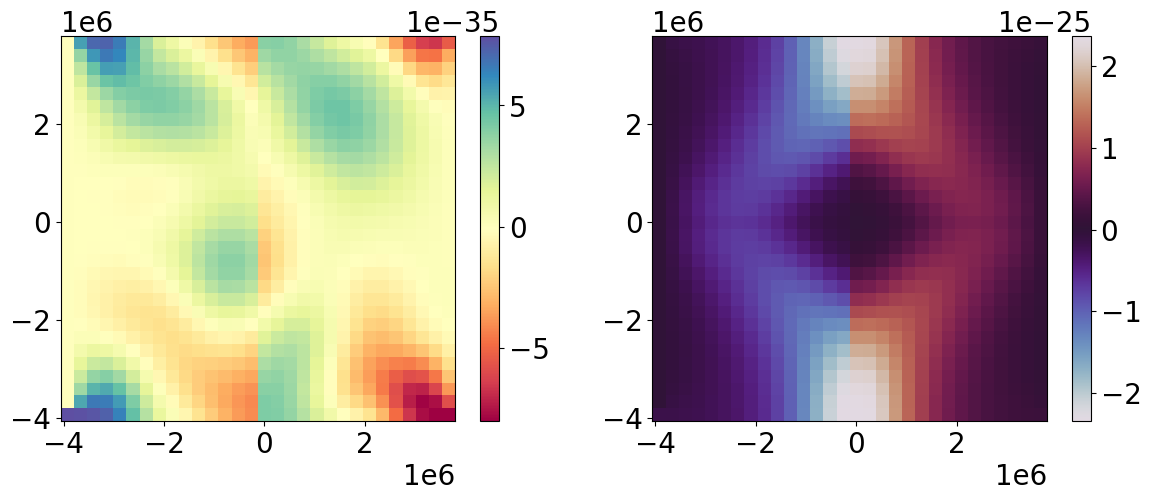

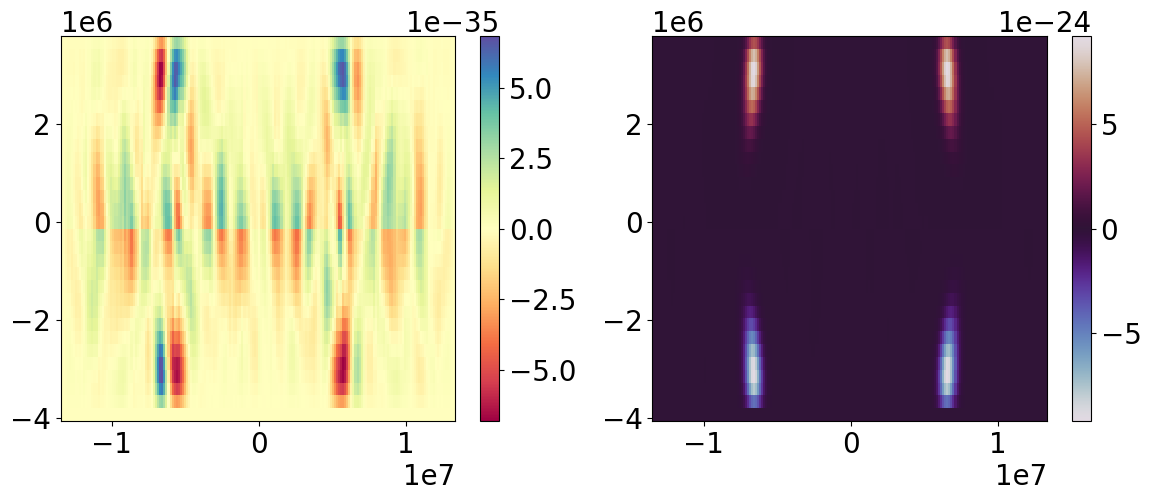

In [45]:
idx = nz//2
idx = 40

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.pcolormesh(kx, ky, np.real(a2[:,:,idx]).T, cmap='Spectral')
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolormesh(kx, ky, np.imag(a2[:,:,idx]).T, cmap='twilight')
plt.colorbar()
plt.show()

idx = 15
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.pcolormesh(kz, kx, np.real(a2[:,idx,:]), cmap='Spectral')
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolormesh(kz, kx, np.imag(a2[:,idx,:]), cmap='twilight')
plt.colorbar()
plt.show()

In [51]:
field.fields[0].a2 = data['a1']
field.fields[0].a1 = data['a2']

In [47]:
grid_shape = grid_xyz.grid_shape
nx, ny, nz = grid_shape
x, y, z = grid_xyz.grid

E_out = [np.zeros(grid_shape, dtype=np.complex128) for _ in range(3)]
B_out = [np.zeros(grid_shape, dtype=np.complex128) for _ in range(3)]

_ = field.calculate_field(t=2e-15, E_out=E_out, B_out=B_out)

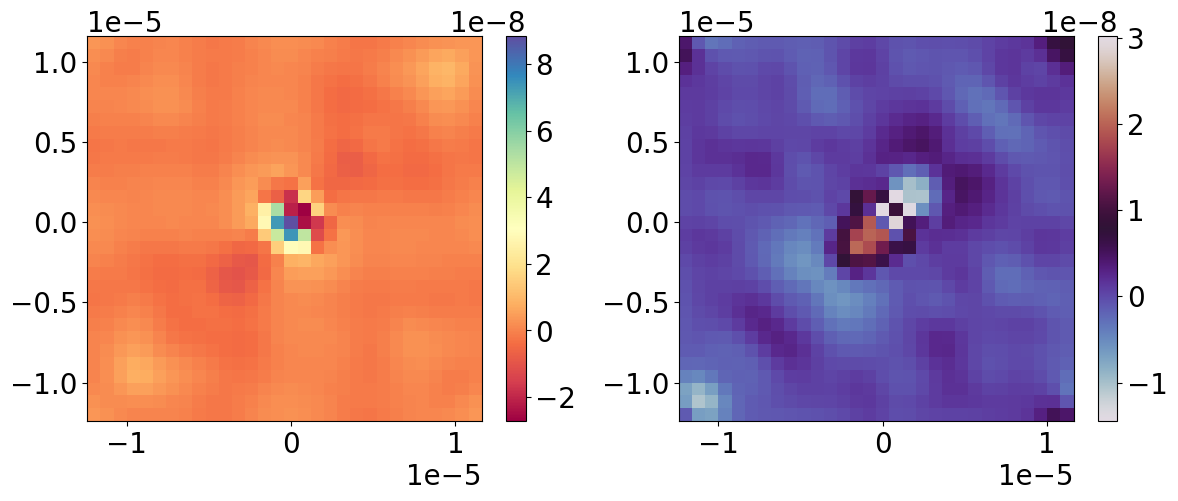

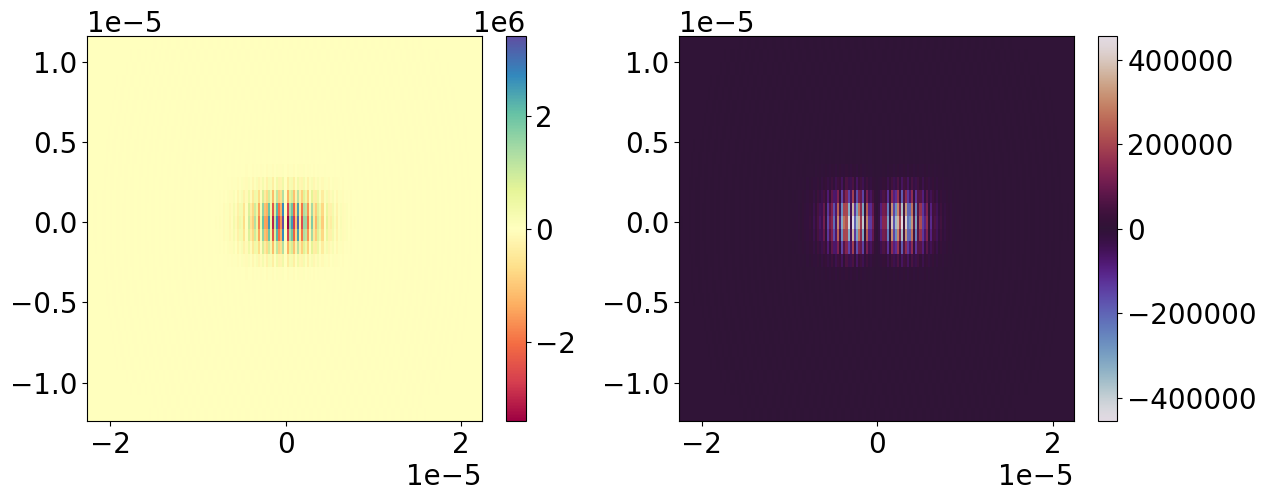

In [48]:
E = E_out[0]
idx = nz//2

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.pcolormesh(x, y, np.real(E[:,:,idx]), cmap='Spectral')
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolormesh(x, y, np.imag(E[:,:,idx]), cmap='twilight')
plt.colorbar()
plt.show()

idx = 15
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.pcolormesh(z, x, np.real(E[:,idx,:]), cmap='Spectral')
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolormesh(z, x, np.imag(E[:,idx,:]), cmap='twilight')
plt.colorbar()
plt.show()

In [49]:
from quvac.integrator.vacuum_emission import VacuumEmission
from quvac.postprocess import VacuumEmissionAnalyzer

# t_grid = np.linspace(-t0, t0, Nt)

amplitude_path = f'{data_folder}/test/2_paraxials_amp.npz'
vacem = VacuumEmission(field, grid_xyz)
vacem.calculate_amplitudes(grid_t, save_path=amplitude_path)

save_path = f'{data_folder}/test/2_paraxials.npz'
analyzer = VacuumEmissionAnalyzer(amplitude_path, save_path)
angles = (0., 0., 0.)
analyzer.get_spectra(angles)

In [50]:
print(analyzer.N_tot)

3.608244531611252e-47


## Implement integrator here

In [17]:
BS = m_e**2 * c**2 / (hbar * e)

class FieldPropagator:
    def __init__(self, a1, a2, grid_xyz):
        self.a1 = a1
        self.a2 = a2
        self.kabs = kabs = grid_xyz.kabs
        self.omega = grid_xyz.kabs * c
        grid_shape = grid_xyz.grid_shape
        e1x, e1y, e1z = (grid_xyz.e1x, grid_xyz.e1y, grid_xyz.e1z)
        e2x, e2y, e2z = (grid_xyz.e2x, grid_xyz.e2y, grid_xyz.e2z)
        self.norm_ifft = grid_xyz.dVk / (2.*pi)**1.5
        kmeshgrid = grid_xyz.kmeshgrid
        self.xyz = xyz = grid_xyz.xyz
        self.k_grid = k_grid = [np.fft.fftshift(kx) for kx in grid_xyz.kgrid]
        k0 = [kx[0] for kx in k_grid]
        # self.k_grid_shifted = [kx - k0x for kx,k0x in zip(kmeshgrid, k0)]

        # k_grid = [np.fft.fftshift(kx) for kx in self.kgrid]
        # phi0 = sum([x[0]*kx[0] for x,kx in zip(self.grid, k_grid)])

        kmeshgrid_shift = np.meshgrid(*k_grid, indexing='ij', sparse=True)

        self.exp_shift_before_fft = sum([kx[0]*(x-x.flatten()[0]) for kx,x in zip(k_grid, self.xyz)])
        self.exp_shift_before_fft = ne.evaluate('exp(-1j*exp_shift_before_fft)',
                                                global_dict=self.__dict__)
        
        self.exp_shift_after_fft = sum([(kx-kx.flatten()[0])*x.flatten()[0] 
                                        for kx,x in zip(kmeshgrid_shift, self.xyz)])
        self.exp_shift_after_fft = ne.evaluate('exp(-1j*exp_shift_after_fft)',
                                                global_dict=self.__dict__)
        
        self.exp_shift_before_ifft = sum([(kx-kx.flatten()[0])*x.flatten()[0] 
                                         for kx,x in zip(kmeshgrid_shift, self.xyz)])
        self.exp_shift_before_ifft = ne.evaluate('exp(1j*exp_shift_before_ifft)',
                                                global_dict=self.__dict__)
        
        self.exp_shift_after_ifft = sum([kx[0]*(x-x.flatten()[0]) for kx,x in zip(k_grid, self.xyz)])
        self.exp_shift_after_ifft = ne.evaluate('exp(1j*exp_shift_after_ifft)',
                                                global_dict=self.__dict__)
        
        # self.exp_shift_ifft = 1

        self.Ef = [ne.evaluate(f"1j*kabs*exp_shift_before_ifft*(e1{ax}*a1 + e2{ax}*a2)",
                               global_dict=self.__dict__)
                   for ax in 'xyz']
        self.Bf = [ne.evaluate(f"1j*kabs*exp_shift_before_ifft*(e2{ax}*a1 - e1{ax}*a2)",
                               global_dict=self.__dict__)
                   for ax in 'xyz']

        self.EB = [pyfftw.zeros_aligned(grid_shape,  dtype='complex128')
                   for _ in range(6)]
        # pyfftw scheme
        self.EB_fftw = [pyfftw.FFTW(a, a, axes=(0, 1, 2),
                                    # direction='FFTW_FORWARD',
                                    direction='FFTW_BACKWARD',
                                    flags=('FFTW_MEASURE', ),
                                    threads=1)
                        for a in self.EB]

    def calculate_field(self, t):
        phase = np.exp(-1j*self.omega*t)
        for i in range(3):
            ne.evaluate('phase * E', global_dict={'E': self.Ef[i]}, out=self.EB[i])
            # self.EB[i] *= self.exp_shift_before_ifft
            self.EB[i] = np.fft.ifftn(self.EB[i], axes=(0,1,2), norm='forward')
            # self.EB_fftw[i].execute()
            self.EB[i] = self.EB[i] * self.norm_ifft #* self.exp_shift_ifft
            
            ne.evaluate('phase * E', global_dict={'E': self.Bf[i]}, out=self.EB[i+3])
            # self.EB[i+3] *= self.exp_shift_before_ifft
            self.EB[i+3] = np.fft.ifftn(self.EB[i+3], axes=(0,1,2), norm='forward')
            # self.EB_fftw[i+3].execute()
            self.EB[i+3] = self.EB[i+3] * self.norm_ifft #* self.exp_shift_ifft
        return self.EB


class Integrator:
    def __init__(self, field, grid):
        self.field = field
        self.grid = grid
        self.grid.get_k_grid()
        self.__dict__.update(self.grid.__dict__)
        self.omega = self.kabs * c

        self.F_expr = F = "0.5 * (Bx**2 + By**2 + Bz**2 - Ex**2 - Ey**2 - Ez**2)"
        self.G_expr = G ="-(Ex*Bx + Ey*By + Ez*Bz)"

        self.U1_expr = [f"4*E{ax}*F + 7*B{ax}*G" for ax in "xyz"]
        self.U2_expr = [f"4*B{ax}*F - 7*E{ax}*G" for ax in "xyz"]

        self.tmp = [pyfftw.zeros_aligned(grid.grid_shape, dtype='complex128') for _ in range(3)]
        # Add number of threads
        self.tmp_fftw = [pyfftw.FFTW(a, a, axes=(0, 1, 2),
                                    direction='FFTW_FORWARD',
                                    flags=('FFTW_MEASURE', ),
                                    threads=1)
                        for a in self.tmp]
        
        self.U1_acc = [np.zeros(grid.grid_shape, dtype='complex128') for _ in range(3)]
        self.U2_acc = [np.zeros(grid.grid_shape, dtype='complex128') for _ in range(3)]

        self.I_11_expr = 'e1x*U1x + e1y*U1y + e1z*U1z'
        self.I_12_expr = 'e1x*U2x + e1y*U2y + e1z*U2z'
        self.I_21_expr = 'e2x*U1x + e2y*U1y + e2z*U1z'
        self.I_22_expr = 'e2x*U2x + e2y*U2y + e2z*U2z'       

    def calculate_one_time_step(self, t):
        EB = self.field.calculate_field(t)
        Ex, Ey, Ez = [E.real for E in EB[:3]]
        Bx, By, Bz = [E.real for E in EB[3:]]

        F = ne.evaluate(self.F_expr)
        G = ne.evaluate(self.G_expr)

        for i,U_expr in enumerate([self.U1_expr, self.U2_expr]):
            for idx in range(3):
                ne.evaluate(U_expr[idx], out=self.tmp[idx])
                self.tmp[idx] = np.fft.fftn(self.tmp[idx], axes=(0,1,2))
                # self.tmp_fftw[idx].execute()
                self.U1_acc[idx] += self.tmp[idx] * np.exp(1j*self.omega*t)
    
    def calculate_time_integral(self, t_grid):
        dt = t_grid[1] - t_grid[0]
        for t in t_grid:
            self.calculate_one_time_step(t)
        for idx in range(3):
            self.U1_acc[idx] *= dt * self.dV
        U1x, U1y, U1z = self.U1_acc
        U2x, U2y, U2z = self.U2_acc

        self.I_11 = ne.evaluate(self.I_11_expr, global_dict=self.__dict__)
        self.I_12 = ne.evaluate(self.I_12_expr, global_dict=self.__dict__)
        self.I_21 = ne.evaluate(self.I_21_expr, global_dict=self.__dict__)
        self.I_22 = ne.evaluate(self.I_22_expr, global_dict=self.__dict__)

    
    def calculate_amplitudes(self):
        prefactor = 1j*np.sqrt(alpha*self.kabs) / (2*pi)**1.5 / 45 / BS**3 * m_e**2 * c**3 / hbar**2
        self.S1 = ne.evaluate(f"prefactor * (I_11 - I_22)",
                               global_dict=self.__dict__)
        self.S2 = ne.evaluate(f"prefactor * (I_12 + I_21)",
                               global_dict=self.__dict__)

    def calculate_total_signal(self):
        self.S = ne.evaluate("S1.real**2 + S1.imag**2 + S2.real**2 + S2.imag**2",
                             global_dict=self.__dict__)
        self.N_xyz = np.fft.fftshift(self.S / (2*pi)**3)
        self.N_tot = ne.evaluate("sum(N_xyz * dVk)",
                                 global_dict=self.__dict__)
        return self.N_tot

In [18]:
data_folder = '/home/maximus/Research/github/quantum-vacuum/data'

data_path = f'{data_folder}/a_spectrum/a1a2.npz'
data = np.load(data_path)
a1, a2 = data['a2'], data['a1']
xyz = grid_xyz.xyz
x, y, z = [ax.flatten() for ax in xyz]
nx, ny, nz = grid_xyz.grid_shape 

In [19]:
field_ = FieldPropagator(np.fft.ifftshift(a1), np.fft.ifftshift(a2), grid_xyz)
kx, ky, kz = field_.k_grid
EB = field_.calculate_field(2e-15)

In [20]:
signal_int = Integrator(field_, grid_xyz)
signal_int.calculate_time_integral(grid_t)
signal_int.calculate_amplitudes()
Ntot = signal_int.calculate_total_signal()

In [21]:
print(Ntot)

12.699003703170844


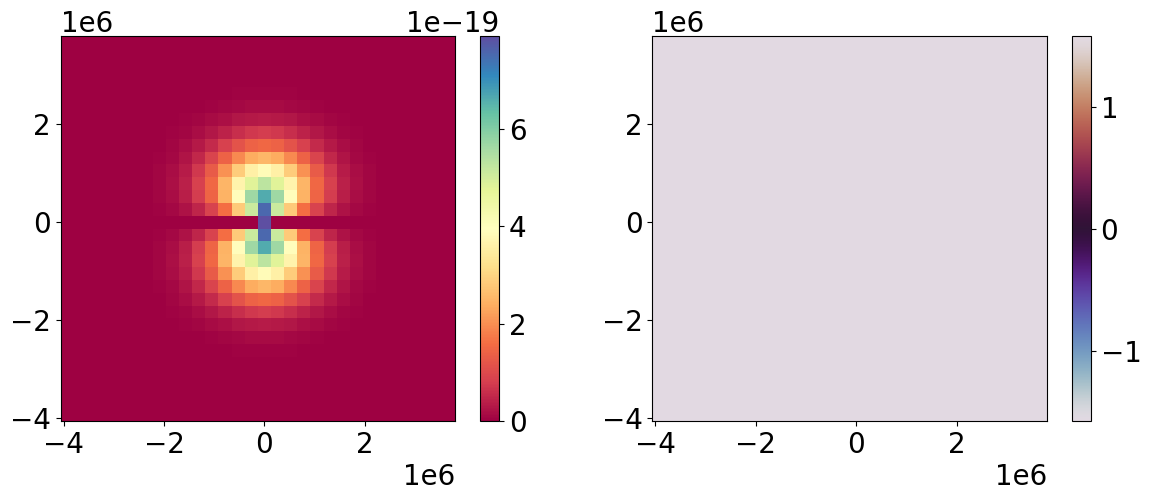

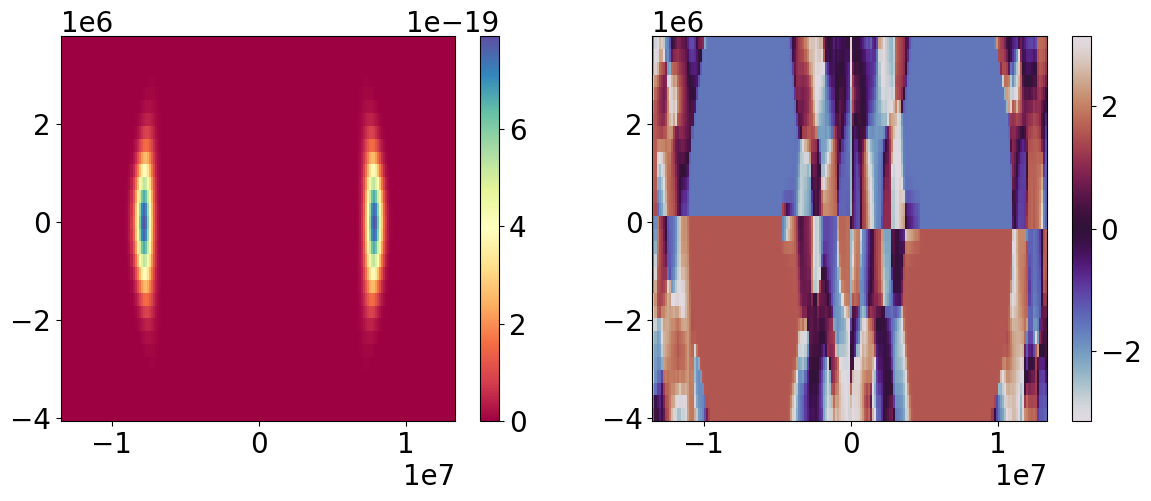

In [83]:
E = EB[0]
idx = 40

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.pcolormesh(kx, ky, np.abs(a1[:,:,idx]), cmap='Spectral')
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolormesh(kx, ky, np.angle(a1[:,:,idx]), cmap='twilight')
plt.colorbar()
plt.show()

idx = ny//2
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.pcolormesh(kz, kx, np.abs(a1[:,idx,:]), cmap='Spectral')
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolormesh(kz, kx, np.angle(a1[:,idx,:]), cmap='twilight')
plt.colorbar()
plt.show()

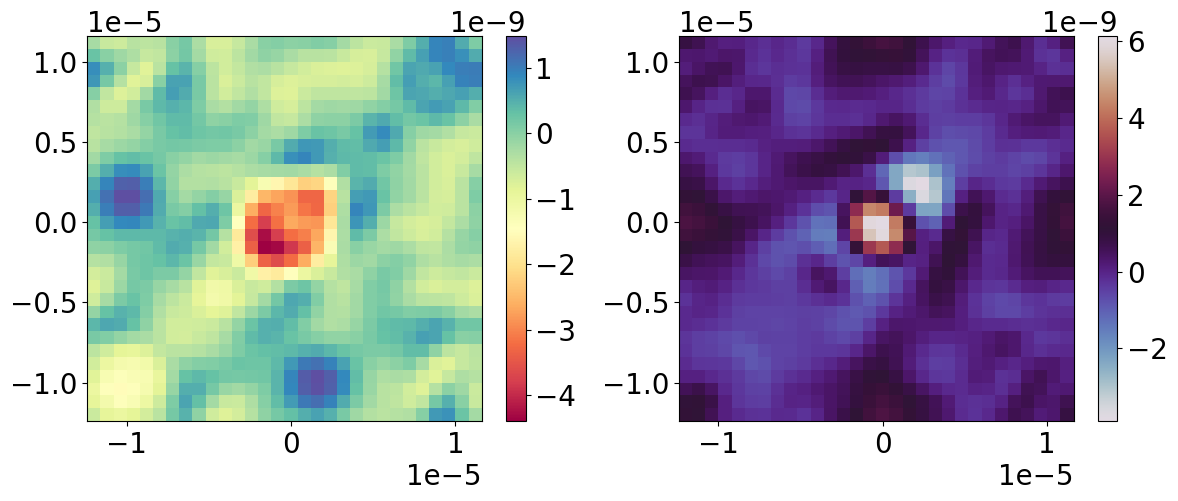

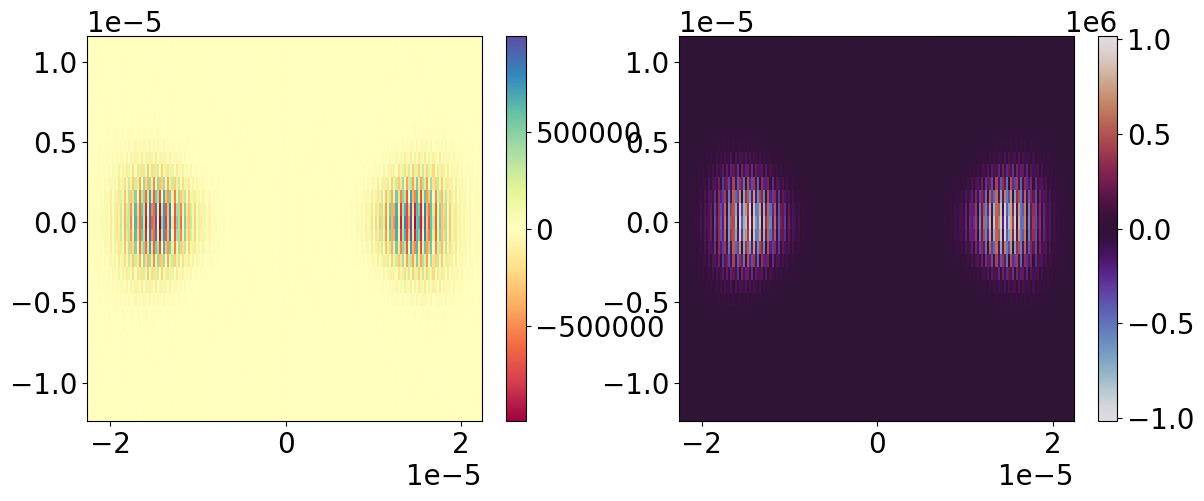

In [22]:
E = EB[0]
idx = nz//2 #nz//2

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.pcolormesh(x, y, np.real(E[:,:,idx]).T, cmap='Spectral')
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolormesh(x, y, np.imag(E[:,:,idx]).T, cmap='twilight')
plt.colorbar()
plt.show()

idx = 15
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.pcolormesh(z, x, np.real(E[:,idx,:]), cmap='Spectral')
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolormesh(z, x, np.imag(E[:,idx,:]), cmap='twilight')
plt.colorbar()
plt.show()

## Test: two paraxial gaussians for different collision angles

In [16]:
tau = 15e-15
W = 25
lam = 0.8e-6
w0 = 4*lam
theta = 145
beta = 90

field_1 = {
    "field_type": "paraxial_gaussian_analytic",
    "focus_x": (0.,0.,0.),
    "focus_t": 0.,
    "theta": 0,
    "phi": 0,
    "beta": 0,
    "lam": lam,
    "w0": w0,
    "tau": tau,
    "W": W,
    "phase0": 0,
}

field_2 = {
    "field_type": "paraxial_gaussian_analytic",
    "focus_x": (0.,0.,0.),
    "focus_t": 0.,
    "theta": theta,
    "phi": 0,
    "beta": beta,
    "lam": lam,
    "w0": w0,
    "tau": tau,
    "W": W,
    "phase0": 0,
}

fields_params = [field_1, field_2]

x0, y0, z0 = 5*c*tau, 15*w0, 5*c*tau
L = np.array([x0, y0, z0])
Nxyz = get_xyz_size(fields_params, L/2)
print(Nxyz)
Nx, Ny, Nz = Nxyz
x = np.linspace(-x0/2,x0/2,2*Nx)
y = np.linspace(-y0/2,y0/2,2*Ny)
z = np.linspace(-z0/2,z0/2,2*Nz)
grid = GridXYZ((x, y, z))

t0 = 2*tau
Nt = get_t_size(-t0, t0, lam)
print(Nt)
t_grid = np.linspace(-t0, t0, Nt)

[72, 30, 104]
135


### Single simulation

In [17]:
N_signal, N_perp = get_two_paraxial_scaling(fields_params)
print(f'Signal (theory): {N_signal:.3f}')

Signal (theory): 4.284


In [18]:
field = ExternalField(fields_params, grid)
vacem = VacuumEmission(field, grid)
vacem.calculate_amplitudes(t_grid)
N_signal_num = vacem.calculate_total_signal()
print(f'Signal (num)   : {N_signal_num:.3f}')

Signal (num)   : 3.232


### Different collision angles

In [4]:
thetas = np.linspace(10,180,18)
Ntots = np.zeros_like(thetas)
Nths = np.zeros_like(thetas)

In [7]:
for i,theta in enumerate(tqdm(thetas)):
    field_2['theta'] = float(theta)
    fields_params = [field_1, field_2]

    x0, y0, z0 = 4*c*tau, 12*w0, 4*c*tau
    L = np.array([x0, y0, z0])
    Nxyz = get_xyz_size(fields_params, L/2)
    print(Nxyz)
    Nx, Ny, Nz = Nxyz
    x = np.linspace(-x0/2,x0/2,Nx)
    y = np.linspace(-y0/2,y0/2,Ny)
    z = np.linspace(-z0/2,z0/2,Nz)
    grid = GridXYZ((x, y, z))
    
    field = ExternalField(fields_params, grid)
    vacem = VacuumEmission(field, grid)
    vacem.calculate_amplitudes(t_grid)
    Ntot = vacem.calculate_total_signal()
    Ntots[i] = Ntot

    N_signal, N_perp = get_two_paraxial_scaling(fields_params)
    Nths[i] = N_signal

  0%|                                                         | 0/18 [00:00<?, ?it/s]

[25, 24, 84]


  6%|██▋                                              | 1/18 [00:02<00:38,  2.29s/it]

[39, 24, 84]


 11%|█████▍                                           | 2/18 [00:05<00:45,  2.85s/it]

[52, 24, 84]


 17%|████████▏                                        | 3/18 [00:09<00:51,  3.42s/it]

[63, 24, 84]


 22%|██████████▉                                      | 4/18 [00:15<01:02,  4.43s/it]

[72, 24, 84]


 28%|█████████████▌                                   | 5/18 [00:21<01:06,  5.12s/it]

[78, 24, 84]


 33%|████████████████▎                                | 6/18 [00:28<01:09,  5.76s/it]

[84, 24, 84]


 39%|███████████████████                              | 7/18 [00:35<01:07,  6.15s/it]

[84, 24, 84]


 44%|█████████████████████▊                           | 8/18 [00:42<01:04,  6.40s/it]

[84, 24, 84]


 50%|████████████████████████▌                        | 9/18 [00:49<00:59,  6.61s/it]

[84, 24, 84]


 56%|██████████████████████████▋                     | 10/18 [00:56<00:53,  6.72s/it]

[84, 24, 84]


 61%|█████████████████████████████▎                  | 11/18 [01:03<00:47,  6.80s/it]

[78, 24, 84]


 67%|████████████████████████████████                | 12/18 [01:10<00:40,  6.83s/it]

[72, 24, 84]


 72%|██████████████████████████████████▋             | 13/18 [01:16<00:32,  6.59s/it]

[63, 24, 84]


 78%|█████████████████████████████████████▎          | 14/18 [01:22<00:25,  6.34s/it]

[52, 24, 84]


 83%|████████████████████████████████████████        | 15/18 [01:26<00:17,  5.71s/it]

[39, 24, 84]


 89%|██████████████████████████████████████████▋     | 16/18 [01:30<00:09,  4.95s/it]

[25, 24, 84]


 94%|█████████████████████████████████████████████▎  | 17/18 [01:32<00:04,  4.09s/it]

[np.int64(11), 24, 84]


100%|████████████████████████████████████████████████| 18/18 [01:33<00:00,  5.19s/it]


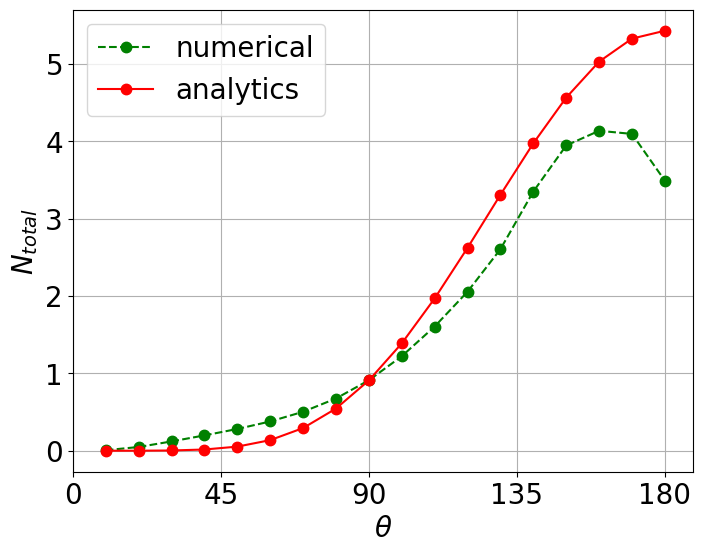

In [8]:
# This is for comparison with Fig.6 from H. Gies, et al "All-optical signatures of 
# strong-field QED in the vacuum emission picture." Physical Review D 97.3 (2018): 036022.

plt.figure(figsize=(8,6))
plt.plot(thetas, Ntots, '.--', color='green', ms=15, label='numerical')
plt.plot(thetas, Nths, '.-', color='red', ms=15, label='analytics')
# plt.yscale('log')
plt.grid()
plt.xlabel('$\\theta$')
plt.ylabel('$N_{total}$')
plt.xticks([45*i for i in range(5)])
# plt.yticks([50*i for i in range(7)])
plt.legend(loc='best')

plt.savefig(f'../imgs/tests/2_paraxial_Ntot_theta_{theta}_beta_{beta}.png',
            bbox_inches='tight')
plt.show()

### Compare with Alex simulations

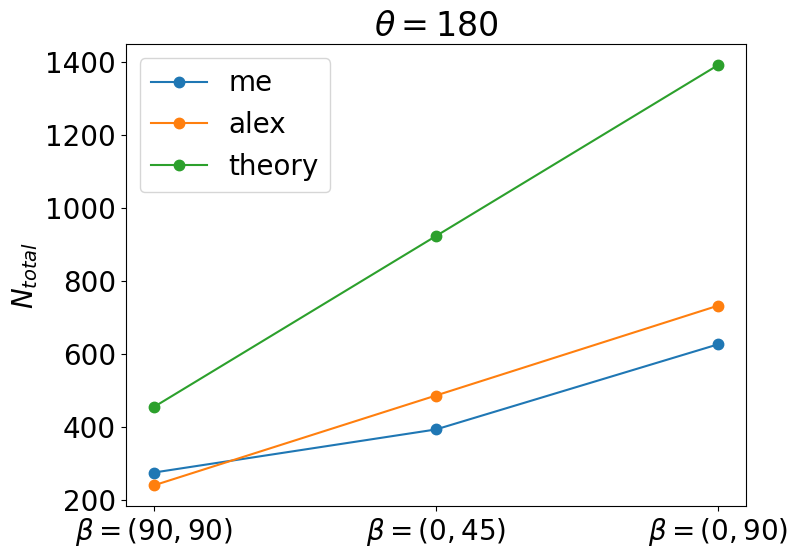

In [57]:
my_data = [274, 392, 625]
alex_data = [239, 485, 731]
theory_data = [454, 922, 1390]

plt.figure()
plt.plot(my_data, '.-', ms=15, label='me')
plt.plot(alex_data, '.-', ms=15, label='alex')
plt.plot(theory_data, '.-', ms=15, label='theory')
plt.xticks([0,1,2], labels=['$\\beta=(90,90)$', '$\\beta=(0,45)$', '$\\beta=(0,90)$'])
plt.ylabel("$N_{total}$")
plt.title('$\\theta = 180$')
plt.legend()
plt.show()

## Test Euler rotation

In [27]:
from scipy.spatial.transform import Rotation
phi = 67*np.pi/180
theta = 145*np.pi/180
beta = 45*np.pi/180
k = np.array([np.cos(phi)*np.sin(theta),
              np.sin(phi)*np.sin(theta),
              np.cos(theta)])
print(f'k      : {k}')
e1 = np.array([np.cos(phi)*np.cos(theta),
               np.sin(phi)*np.cos(theta),
               -np.sin(theta)])
e2 = np.array([-np.sin(phi),
               np.cos(phi),
               0.])
eb = e1 * np.cos(beta) + e2 * np.sin(beta)

rotation = Rotation.from_euler('ZYZ', (phi,theta,beta))
rotation_bwd = rotation.inv()

k_rotated = rotation_bwd.apply(k)
print(f'k(rot) : {k_rotated}')

eb_rotated = rotation_bwd.apply(eb)
print(f'eb     : {eb}')
print(f'eb(rot): {eb_rotated}')

eb_ = rotation.apply(eb_rotated)
print(f'eb...  : {eb_}')

k      : [ 0.22411417  0.52797989 -0.81915204]
k(rot) : [-2.77555756e-17 -5.55111512e-17  1.00000000e+00]
eb     : [-0.87721762 -0.25689352 -0.40557979]
eb(rot): [ 1.00000000e+00 -8.32667268e-17  0.00000000e+00]
eb...  : [-0.87721762 -0.25689352 -0.40557979]


## Random tests

In [19]:
from astropy.coordinates import cartesian_to_spherical

xyz = x,y,z = [np.linspace(-1,1,100)[:,None,None],
               np.linspace(-1,1,100)[None,:,None],
               np.linspace(-1,1,100)[None,None,:]]
sph = r,theta,phi = cartesian_to_spherical(*xyz)
sph = r,theta,phi = [np.array(coord) for coord in sph]
theta += np.pi/2
print(r.min(), r.max())
print('='*20)
print(theta.min(), theta.max())
print('='*20)
print(phi.min(), phi.max())
print('='*20)

0.017495462702715854 1.7320508075688772
0.014284013928896666 3.1273086396608964
0.010100666585321971 6.273084640594265


## Check maxwell class

In [2]:
# Define field parameters
tau = 25e-15
W = 25
lam = 0.8e-6
w0 = 2*lam
theta = 90
beta = 90

# Define fields
field_1 = {
    "field_type": "paraxial_gaussian_maxwell",
    "focus_x": [0.,0.,0.],
    "focus_t": 0.,
    "theta": 0,
    "phi": 0,
    "beta": 0,
    "lam": lam,
    "w0": w0,
    "tau": tau,
    "W": W,
    "phase0": 0,
}

fields_params = [field_1]

x0, y0, z0 = 5*c*tau, 12*w0, 5*c*tau
box_size = np.array([x0, y0, z0])
Nxyz = get_xyz_size(fields_params, box_size/2)
Nx, Ny, Nz = Nxyz
x = np.linspace(-x0/2,x0/2,Nx)
y = np.linspace(-y0/2,y0/2,Ny)
z = np.linspace(-z0/2,z0/2,Nz)
grid = GridXYZ((x, y, z))

t0 = 2*tau
Nt = get_t_size(-t0, t0, lam)
t_grid = np.linspace(-t0, t0, Nt)

In [3]:
field = ParaxialGaussianMaxwell(field_1, grid)

In [4]:
E, B = field.calculate_field(t=10e-15)

In [5]:
get_field_energy(E, B, field.dV)

np.float64(24.999999999999915)

In [6]:
W = get_field_energy_kspace(field.a1, field.a2, field.kabs, field.dVk)
W

np.float64(25.00000000000037)

## Check how various DFTs work

In [20]:
import numpy as np
import pyfftw
from scipy.constants import pi
from scipy.special import sinc

def gauss(x, a=1.):
    return np.exp(-a*x**2)

def gauss_f(kx, a=1.):
    return np.sqrt(pi/a) * np.exp(-kx**2/(4*a))

def gauss_c(x, a=1.):
    return np.exp(-1j*pi*a*x**2)

def gauss_c_f(kx, a=1.):
    return 1/np.sqrt(a) * np.exp(-1j*pi/4) * np.exp(1j*kx**2/(4*pi*a))

def exp_c(x, a=1.):
    return np.exp(1j*a*x)

def exp_c_f(kx, x0, a=1.):
    return 2*x0 * sinc(x0*(kx-a))

def cft_numpy(arr, x, fft_module='numpy'):
    fft_module = np.fft if fft_module == 'numpy' else pyfftw.interfaces.numpy_fft
    dx = x[1] - x[0]
    kx = 2.*pi*np.fft.fftshift(np.fft.fftfreq(len(x), dx))
    kx0 = kx[0]

    arr_k = fft_module.fftn(arr*np.exp(-1j*kx0*(x-x[0])))
    arr_k_shifted = dx * arr_k * np.exp(-1j*kx*x[0]+1j*kx0*x[0])
    return arr_k_shifted, kx

def icft_numpy(arr_k, kx, fft_module='numpy'):
    fft_module = np.fft if fft_module == 'numpy' else pyfftw.interfaces.numpy_fft
    dkx = kx[1] - kx[0]
    kx = np.fft.fftshift(kx.copy())
    x = np.fft.fftshift(np.fft.fftfreq(len(kx), dkx/(2*pi)))

    arr_k = np.fft.fftshift(arr_k)
    arr = fft_module.ifftn(arr_k*np.exp(1j*(kx-kx[0])*x[0]), norm='forward')
    arr_shifted = dkx/(2*pi) * arr * np.exp(1j*kx[0]*x-1j*kx[0]*x[0])
    return arr_shifted, x

# Write analogs with pyfftw
def cft_pyfftw(arr, x):
    dx = x[1] - x[0]
    kx = 2*pi*np.fft.fftshift(np.fft.fftfreq(len(x), dx))
    kx0 = kx[0]

    arr = arr.astype(np.complex128) * np.exp(-1j*kx0*(x-x[0]))
    arr_k = np.zeros(arr.shape, dtype=np.complex128)
    pyfftw_scheme = pyfftw.FFTW(arr, arr_k, axes=(0,),
                                direction='FFTW_FORWARD',
                                flags=('FFTW_MEASURE', ),
                                threads=1)
    pyfftw_scheme.execute()
    
    arr_k_shifted = dx * arr_k * np.exp(-1j*kx*x[0]+1j*kx0*x[0])
    return arr_k_shifted, kx

def icft_pyfftw(arr_k, kx):
    dkx = kx[1] - kx[0]
    x = np.fft.fftshift(np.fft.fftfreq(len(kx), dkx/(2*pi)))
    kx = np.fft.fftshift(kx.copy())

    arr_k = np.fft.fftshift(arr_k)
    arr_k = arr_k.astype(np.complex128) * np.exp(1j*(kx-kx[0])*x[0])
    arr = np.zeros_like(arr_k)
    pyfftw_scheme = pyfftw.FFTW(arr_k, arr, axes=(0,),
                                direction='FFTW_BACKWARD',
                                flags=('FFTW_MEASURE', ),
                                threads=1)
    pyfftw_scheme.execute()
    
    arr_shifted = dkx/(2*pi) * arr * np.exp(1j*kx[0]*x-1j*kx[0]*x[0])
    return arr_shifted, x

200
[1.91516960e-174 5.48518544e-171 1.45021313e-167 3.53939303e-164
 7.97410943e-161]
[1.91516960e-174 5.48518544e-171 1.45021313e-167 3.53939303e-164
 7.97410943e-161]
True


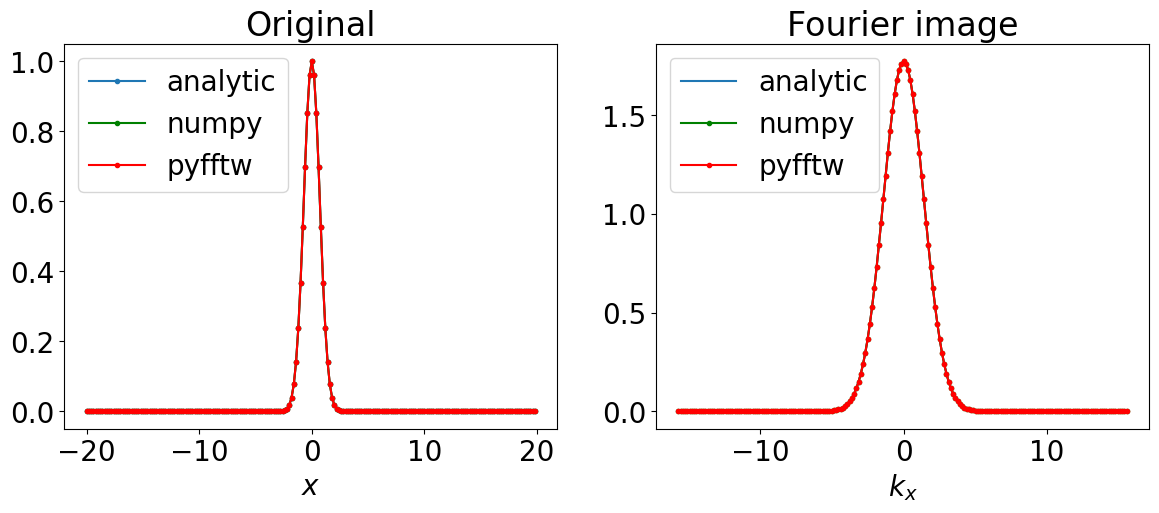

In [18]:
x0 = 20
dx = 0.2
Nx = int(2*x0/dx)
# dx = 2*x0/Nx
x = np.linspace(-x0, x0, Nx, endpoint=Nx%2)
kx = np.fft.fftshift(2.*pi*np.fft.fftfreq(Nx, dx))
print(Nx)

a = 1.
f = gauss(x, a)
# Analytic CFT
fk = gauss_f(kx, a)
print(f[:5])

# Numeric
module = 'numpy'
fk_np, kx_fft = cft_numpy(f, x, fft_module=module)
f_np, x_fft = icft_numpy(fk_np, kx_fft, fft_module=module)

print(f[:5])
fk_pyfftw, kx_pyfftw = cft_pyfftw(f, x)
f_pyfftw, x_pyfftw = icft_pyfftw(fk_pyfftw, kx_pyfftw)

print(np.allclose(f, f_np, rtol=1e-1))

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(x, f, '.-', label='analytic')
plt.plot(x_fft, f_np, '.-', color='green', label='numpy')
plt.plot(x_pyfftw, f_pyfftw, '.-', color='red', label='pyfftw')
plt.xlabel('$x$')
plt.title('Original')
plt.legend(loc='upper left')

plt.subplot(1,2,2)
plt.plot(kx, fk, label='analytic')
plt.plot(kx_fft, fk_np, '.-', color='green', label='numpy')
plt.plot(kx, fk_pyfftw, '.-', color='red', label='pyfftw')
plt.xlabel('$k_x$')
plt.title('Fourier image')
plt.legend(loc='upper left')
plt.show()

2000
[0.96496603+0.26237485j 0.9506468 +0.31027515j 0.93395144+0.35739993j
 0.91492169+0.40363139j 0.89360512+0.44885398j]
[0.96496603+0.26237485j 0.9506468 +0.31027515j 0.93395144+0.35739993j
 0.91492169+0.40363139j 0.89360512+0.44885398j]
True


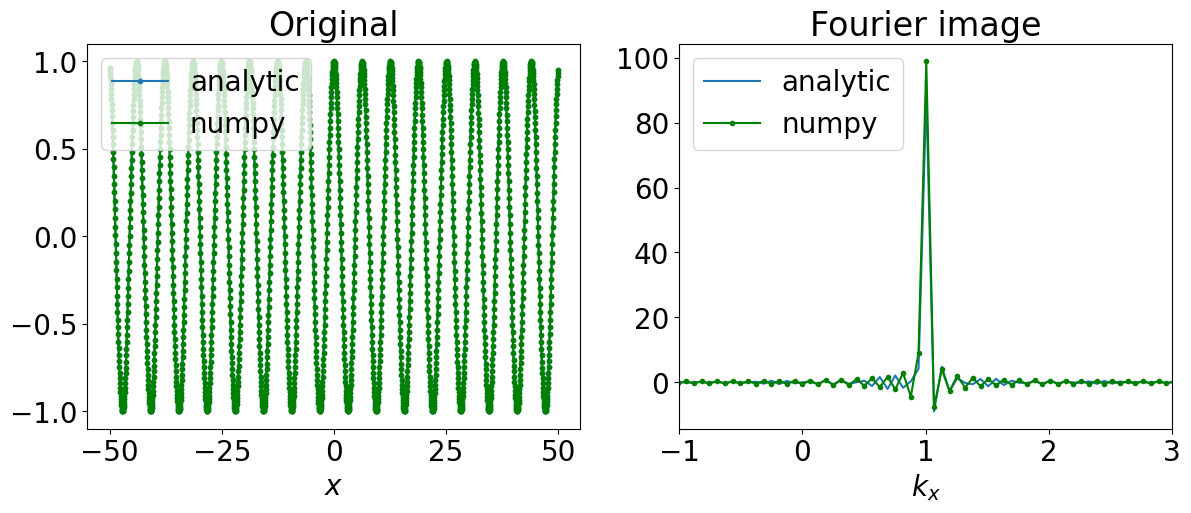

In [34]:
x0 = 50
dx = 0.05
Nx = int(2*x0/dx)
# dx = 2*x0/Nx
x = np.linspace(-x0, x0, Nx, endpoint=Nx%2)
kx = np.fft.fftshift(2.*pi*np.fft.fftfreq(Nx, dx))
print(Nx)

a = 1.
f = exp_c(x, a)
# Analytic CFT
fk = exp_c_f(kx, x0, a)
print(f[:5])

# Numeric
module = 'numpy'
fk_np, kx_fft = cft_numpy(f, x, fft_module=module)
f_np, x_fft = icft_numpy(fk_np, kx_fft, fft_module=module)

print(f[:5])
fk_pyfftw, kx_pyfftw = cft_pyfftw(f, x)
f_pyfftw, x_pyfftw = icft_pyfftw(fk_pyfftw, kx_pyfftw)

print(np.allclose(f, f_np, rtol=1e-1))

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(x, f, '.-', label='analytic')
plt.plot(x_fft, f_np, '.-', color='green', label='numpy')
# plt.plot(x_pyfftw, f_pyfftw, '.-', color='red', label='pyfftw')
plt.xlabel('$x$')
plt.title('Original')
plt.legend(loc='upper left')

plt.subplot(1,2,2)
plt.plot(kx, fk, label='analytic')
plt.plot(kx_fft, fk_np, '.-', color='green', label='numpy')
# plt.plot(kx, fk_pyfftw, '.-', color='red', label='pyfftw')
plt.xlim([-1,3])
plt.xlabel('$k_x$')
plt.title('Fourier image')
plt.legend(loc='upper left')
plt.show()

2000
[-200.  -199.8 -199.6 -199.4 -199.2]
[0.  0.2 0.4 0.6 0.8]
True


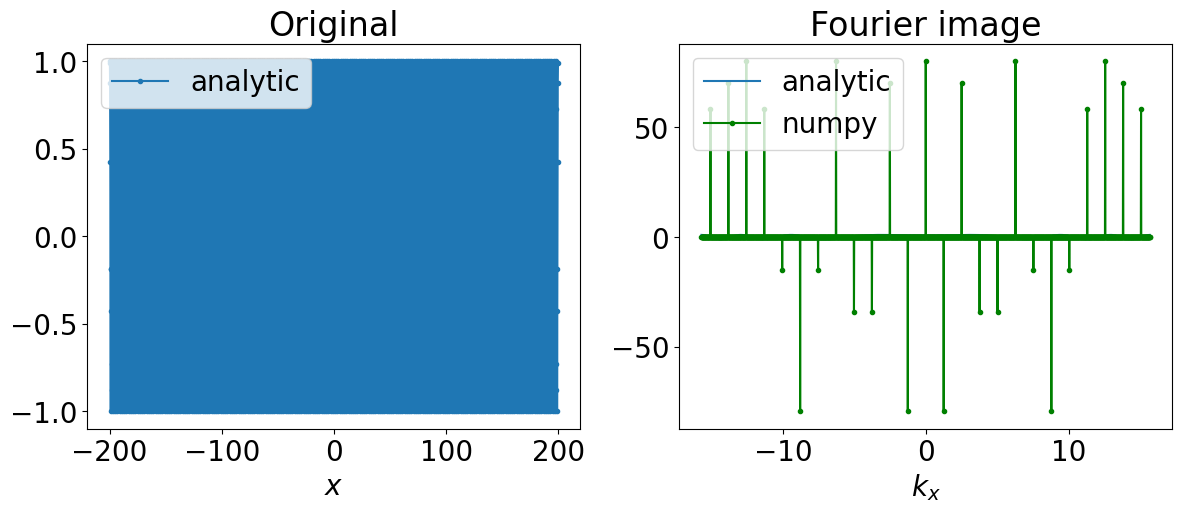

In [13]:
x0 = 200
dx = 0.2
Nx = int(2*x0/dx)
# dx = 2*x0/Nx
x = np.linspace(-x0, x0, Nx, endpoint=Nx%2)
kx = np.fft.fftshift(2.*pi*np.fft.fftfreq(Nx, dx))
print(Nx)

a = 1.
f = gauss_c(x, a)
# Analytic CFT
fk = gauss_c_f(kx, a)

# Numeric
module = 'numpy'
fk_np, kx_fft = cft_numpy(f, x, fft_module=module)
f_np, x_fft = icft_numpy(fk_np, kx_fft, fft_module=module)
print(x[:5])
print(np.fft.fftshift(x_fft)[:5])

fk_pyfftw, kx_pyfftw = cft_pyfftw(f, x)
f_pyfftw, x_pyfftw = icft_pyfftw(fk_pyfftw, kx_pyfftw)

print(np.allclose(f, np.fft.fftshift(f_np), rtol=1e-2))

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(x, f.real, '.-', label='analytic')
# plt.plot(np.fft.fftshift(x_fft), np.fft.fftshift(f_np.real), '.-', color='green', label='numpy')
# plt.plot(np.fft.fftshift(x_pyfftw), np.fft.fftshift(f_pyfftw), '.-', color='red', label='pyfftw')
plt.xlabel('$x$')
plt.title('Original')
plt.legend(loc='upper left')

plt.subplot(1,2,2)
plt.plot(kx, fk.real, label='analytic')
plt.plot(kx, np.fft.fftshift(fk_np.real), '.-', color='green', label='numpy')
# plt.plot(kx, np.fft.fftshift(fk_np).real, '.-', color='green', label='numpy')
# plt.plot(kx, np.fft.fftshift(fk_pyfftw), '.-', color='red', label='pyfftw')
plt.xlabel('$k_x$')
plt.title('Fourier image')
plt.legend(loc='upper left')
plt.show()

In [136]:
x = np.array([1, 2-1j, -1j, -1+2j])
y = np.fft.fft(x)
print(y)

[ 2.+0.j -2.-2.j  0.-2.j  4.+4.j]


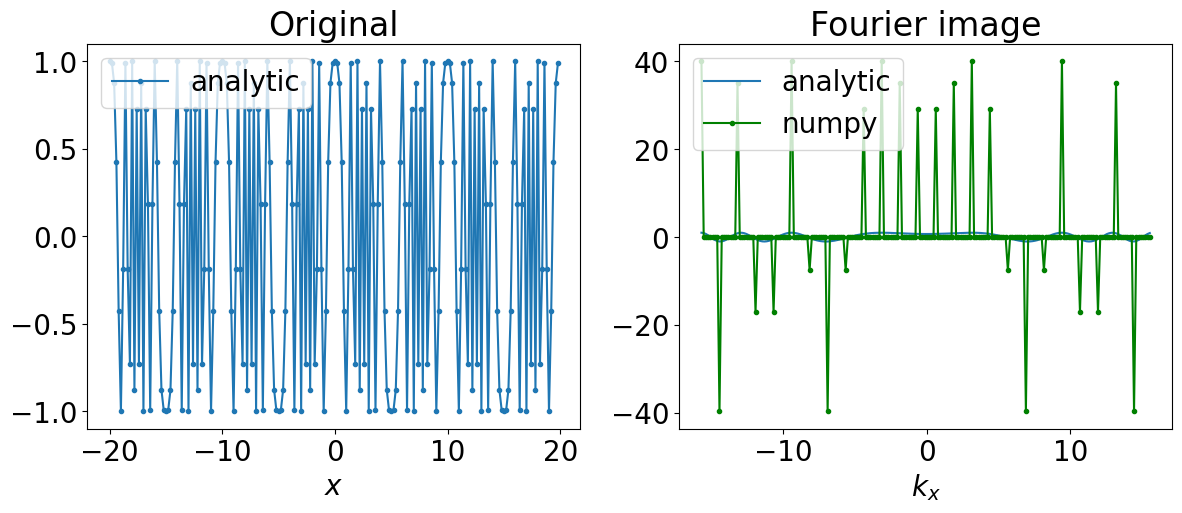

In [19]:
x = np.linspace(-x0, x0, Nx, endpoint=Nx%2)
kx = np.fft.fftshift(2.*pi*np.fft.fftfreq(Nx, dx))
f = gauss_c(x)
fk = gauss_c_f(kx)

fk_np = np.fft.fft(f)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(x, f.real, '.-', label='analytic')
# plt.plot(np.fft.fftshift(x_fft), np.fft.fftshift(f_np.real), '.-', color='green', label='numpy')
# plt.plot(np.fft.fftshift(x_pyfftw), np.fft.fftshift(f_pyfftw), '.-', color='red', label='pyfftw')
plt.xlabel('$x$')
plt.title('Original')
plt.legend(loc='upper left')

plt.subplot(1,2,2)
plt.plot(kx, fk.real, label='analytic')
# plt.plot(kx, fk.imag, color='green')
plt.plot(kx, np.fft.fftshift(fk_np).real, '.-', color='green', label='numpy')
# plt.plot(kx, np.fft.fftshift(fk_pyfftw), '.-', color='red', label='pyfftw')
plt.xlabel('$k_x$')
plt.title('Fourier image')
plt.legend(loc='upper left')
plt.show()

In [19]:
from scipy import integrate

def cft(g, f):
    """Numerically evaluate the Fourier Transform of g for the given frequencies"""    
    result = np.zeros(len(f), dtype=complex)
    
    # Loop over all frequencies and calculate integral value
    for i, ff in enumerate(f):
        # Evaluate the Fourier Integral for a single frequency ff, 
        # assuming the function is time-limited to abs(t)<5
        result[i] = complex_quad(lambda t: g(t)*np.exp(-2j*np.pi*ff*t), -5, 5)
    return result

def complex_quad(g, a, b):
    """Return definite integral of complex-valued g from a to b, 
    using Simpson's rule"""
    # 2501: Amount of used samples for the trapezoidal rule
    t = np.linspace(a, b, 2501)  
    x = g(t)
    return integrate.simpson(y=x, x=t)

In [20]:
t = np.linspace(-2,2, 1000)
f = np.linspace(-5, 5, 1000)

R = cft(gauss_c, f)
ref = gauss_c_f(2*pi*f)

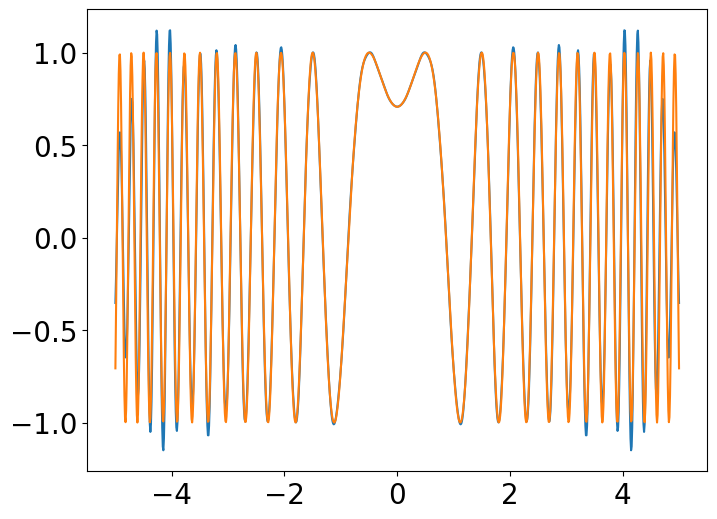

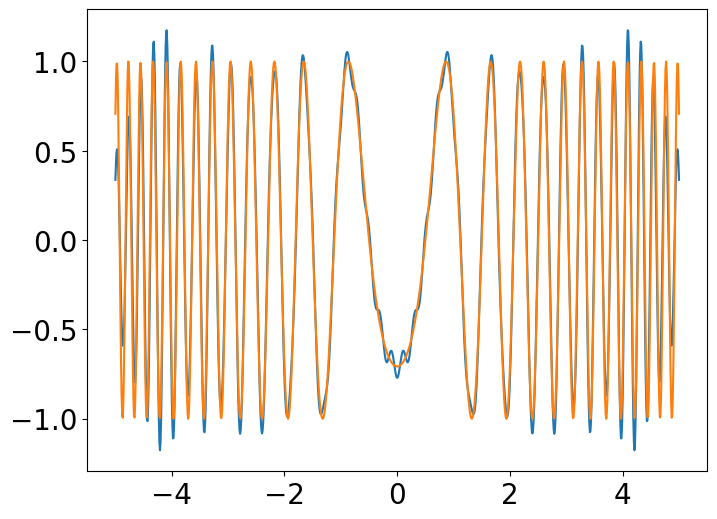

In [22]:
plt.figure()
plt.plot(f, R.real)
plt.plot(f, ref.real)
plt.show()

plt.figure()
plt.plot(f, R.imag)
plt.plot(f, ref.imag)
plt.show()